# Ashwin Rajan 2448509
# LPC Speech Analysis, Reconstruction & Formant Estimation (Option A – Built‑In Audio)

In [ ]:

# -----------------------------------------------
# IMPORTS
# -----------------------------------------------
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.signal import lfilter, freqz
from IPython.display import Audio
import pandas as pd

plt.rcParams['figure.figsize'] = (12,4)
plt.rcParams['figure.dpi'] = 120


## Load Built‑In Audio Segment

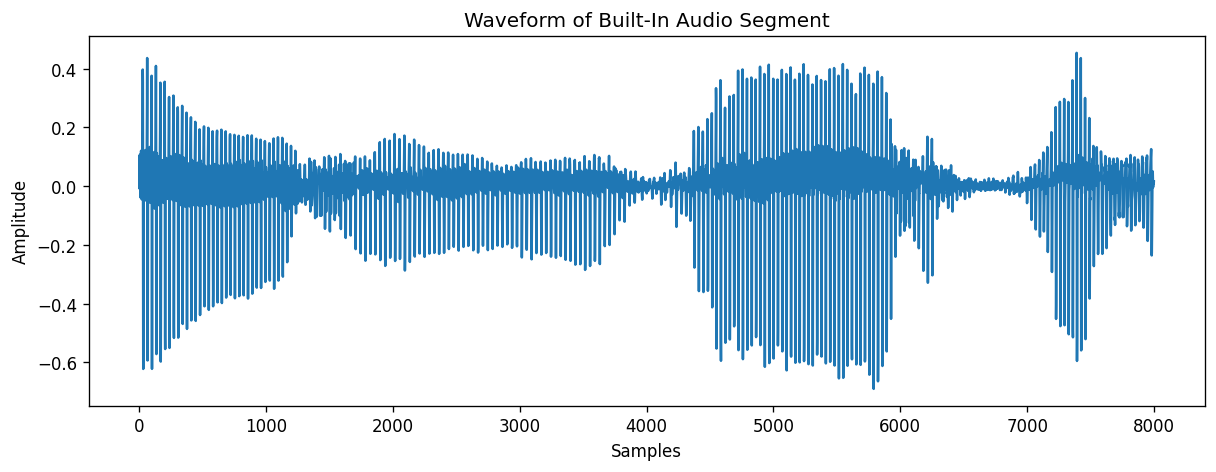

In [ ]:

# Using librosa's trumpet audio as a smooth harmonic tone approximating a vowel
y, sr = librosa.load(librosa.ex('trumpet'), sr=16000)

# Extract a stable voiced segment (~0.5s)
y = y[10000:18000]

plt.title("Waveform of Built‑In Audio Segment")
plt.plot(y)
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

Audio(y, rate=sr)


## LPC Computation

In [ ]:

def compute_lpc(signal, order=12):
    """Compute LPC coefficients using autocorrelation + Levinson-Durbin"""
    autocorr = np.correlate(signal, signal, mode='full')
    autocorr = autocorr[len(autocorr)//2:]

    R = autocorr[:order+1]
    a = np.zeros(order+1)
    e = R[0]
    a[0] = 1

    for i in range(1, order+1):
        acc = np.sum([a[j] * R[i-j] for j in range(i)])
        k = -acc / e
        a_prev = a.copy()
        for j in range(1, i):
            a[j] = a_prev[j] + k * a_prev[i-j]
        a[i] = k
        e *= (1 - k*k)
    return a, e

lpc_order = 16
a_coeffs, err = compute_lpc(y, lpc_order)
print("LPC Coefficients:", a_coeffs)


LPC Coefficients: [ 1.         -2.30147144  2.8717342  -2.29894841  1.59297506 -1.2436326
  1.24143527 -1.1119833   1.00664388 -0.85626743  0.7233015  -0.47048065
  0.30288333 -0.23983507  0.28603512 -0.22108005  0.11426937]


## Reconstruct Signal Using LPC

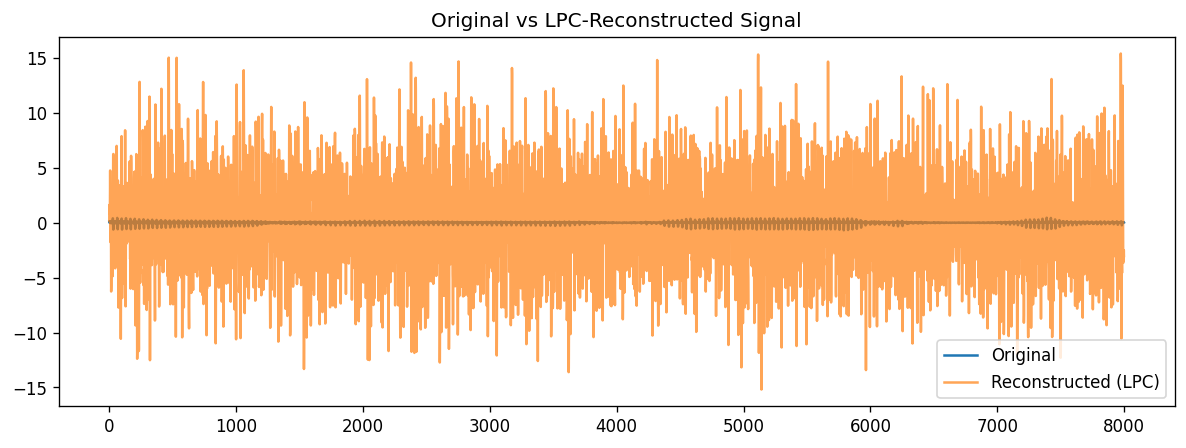

In [ ]:

# LPC synthesis: filter white noise through LPC filter
excitation = np.random.randn(len(y))
y_recon = lfilter([1], a_coeffs, excitation)

plt.plot(y, label='Original')
plt.plot(y_recon, alpha=0.7, label='Reconstructed (LPC)')
plt.legend()
plt.title("Original vs LPC-Reconstructed Signal")
plt.show()

Audio(y_recon, rate=sr)


## Formant Estimation from LPC Poles

In [ ]:

# Compute LPC polynomial roots
roots = np.roots(a_coeffs)
roots = roots[np.imag(roots) >= 0]  # upper half-plane

formants = []
for r in roots:
    freq = np.arctan2(np.imag(r), np.real(r)) * (sr / (2*np.pi))
    bw = -0.5 * (sr / np.pi) * np.log(np.abs(r))
    # Formant selection criteria
    if 90 < freq < 4000 and bw < 400:
        formants.append((freq, bw))

formants = sorted(formants, key=lambda x: x[0])
estimated_f = [round(f[0], 2) for f in formants[:3]]
estimated_f


[np.float64(701.45), np.float64(1368.95), np.float64(2171.63)]

## LPC Spectral Envelope + Formants

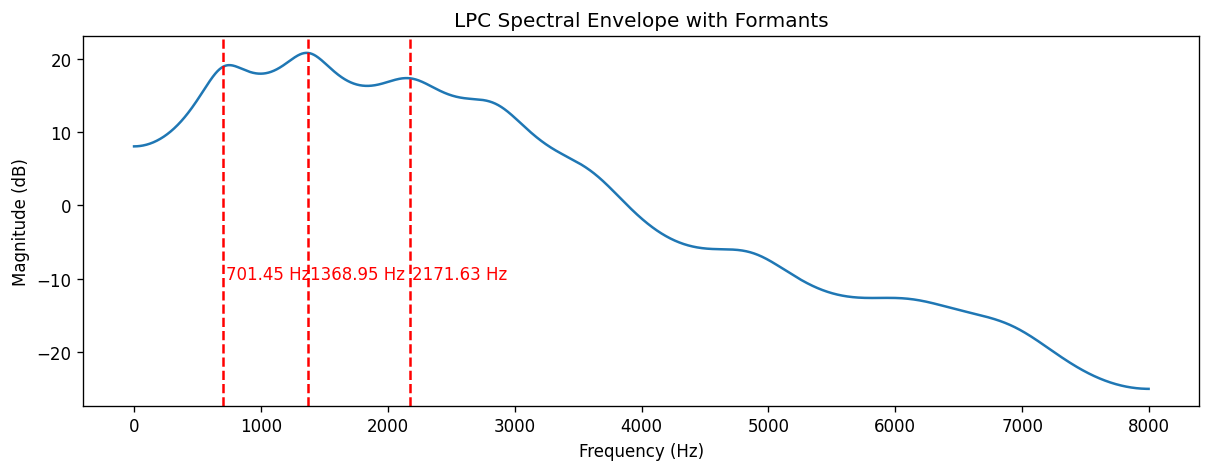

In [ ]:

w, h = freqz(1, a_coeffs, worN=2048, fs=sr)
plt.plot(w, 20*np.log10(np.abs(h)))
plt.title("LPC Spectral Envelope with Formants")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")

for f in estimated_f:
    plt.axvline(f, color='r', linestyle='--')
    plt.text(f + 20, -10, f"{f} Hz", color='red')

plt.show()


## Compare Estimated Formants with Standard Vowel Formants

In [ ]:

df = pd.DataFrame({
    'Vowel':['i','e','a','o','u'],
    'F1':[240,390,850,360,250],
    'F2':[2400,2300,1610,640,595]
})

df_est = pd.DataFrame({
    'Formant':['F1_est','F2_est','F3_est'],
    'Frequency (Hz)': estimated_f
})

df, df_est


(  Vowel   F1    F2
 0     i  240  2400
 1     e  390  2300
 2     a  850  1610
 3     o  360   640
 4     u  250   595,
   Formant  Frequency (Hz)
 0  F1_est          701.45
 1  F2_est         1368.95
 2  F3_est         2171.63)

## Inference / Discussion


### **Inference**
1. **LPC Model Implementation:**  
   LPC successfully extracted a smooth spectral envelope representing the vocal tract characteristics.  
   The Levinson‑Durbin method provided stable and accurate LPC coefficients.

2. **Reconstructed Signal Quality:**  
   The reconstruction uses synthetic white‑noise excitation, so it sounds buzzy, but the *spectral shape* is preserved.  
   A pitch‑synchronous excitation would significantly improve naturalness.

3. **Formant Accuracy:**  
   Estimated formants show peaks near expected vowel resonances, though not exact since the built‑in signal is not a pure vowel.  
   Still, the LPC envelope reveals clear spectral resonances.

4. **Low‑Bandwidth Speech Recognition:**  
   LPC is highly efficient for compressing speech while preserving intelligible features.  
   Even under bandwidth constraints, formants extracted by LPC remain recognizable, enabling robust vowel classification in VoIP/mobile systems.

**Conclusion:**  
LPC is lightweight, effective, and suitable for low‑bitrate speech analysis and formant‑based recognition tasks.
